In [11]:
# IMPORTANT: change this to your locations
model_h5_file_location = f'/scratch/ms7490/code/splicing_library_analysis/2022_03_11_figures/models/custom_adjacency_regularizer_20210731_124_step3.h5'
data_folder = f'/scratch/ms7490/code/splicing_library_analysis/2022_03_11_figures/data'
BS115_data_folder = '/home/ms7490/scratch/code/splicing_library_analysis/data/ES7/'
BS06911A_coupling_csv_path = '/scratch/ms7490/data/rna_data/Sample_BS06911A/coupling.csv'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import patches as pat
from matplotlib import transforms
from matplotlib.collections import PatchCollection
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from joblib import load, dump
import re
import scipy.cluster.hierarchy as sch

# custom code
import figutils
import sequence_logo
from quad_model import *
import kl
import force
from scipy.stats import gaussian_kde
import read_datasets

from collections.abc import Iterable

%matplotlib inline

2022-09-23 00:21:05.618788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2022-09-23 00:21:05.618810: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
plt.style.use('clean.mplstyle')

# Load data and models

In [5]:
xTr = load(os.path.join(data_folder, f'xTr_ES7_HeLa_ABC.pkl'))
yTr = load(os.path.join(data_folder, f'yTr_ES7_HeLa_ABC.pkl'))
xTe = load(os.path.join(data_folder, f'xTe_ES7_HeLa_ABC.pkl'))
yTe = load(os.path.join(data_folder, f'yTe_ES7_HeLa_ABC.pkl'))

In [6]:
def binary_KL(y_true, y_pred):
    return tf.keras.backend.mean(
        tf.keras.backend.binary_crossentropy(y_true, y_pred)
        - tf.keras.backend.binary_crossentropy(y_true, y_true),
        axis=-1,
    )

In [7]:
model_fname = model_h5_file_location
model = tf.keras.models.load_model(model_fname)

2022-09-23 00:21:11.046319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2022-09-23 00:21:11.046344: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-23 00:21:11.046361: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cm001.hpc.nyu.edu): /proc/driver/nvidia/version does not exist
2022-09-23 00:21:11.046565: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.evaluate(xTe, yTe)

2022-09-23 00:21:11.702377: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1499/1499 [==============================] - 12s 8ms/step - loss: 0.1249 - binary_KL: 0.0999


[0.12492550909519196, 0.09990660846233368]

In [9]:
num_seq_filters = model.get_layer('qc_incl').kernel.shape[2]
num_struct_filters = model.get_layer('c_incl_struct').kernel.shape[2]

position_bias_size = model.get_layer('position_bias_incl').kernel.shape[0]
struct_filter_width = model.get_layer("c_incl_struct").kernel.shape[0]
input_length = model.input[0].shape[1]

# Figure 1c

In [12]:
all_barcode_statistics = read_datasets.read_all_datasets_no_filtering(BS115_data_folder)

In [13]:
NUM_SPLICING_OUTCOMES = 7
summary_data = [[] for i in range(NUM_SPLICING_OUTCOMES)]
for idx in [0, 1, 2]:
    barcode_statistics = all_barcode_statistics[idx]
    statistics = barcode_statistics[barcode_statistics.badly_coupled == False].drop(columns=["exon","num_dna_reads"]).sum()
    statistics = 100*statistics/statistics.sum()
    summary_data[0].append(statistics.num_exon_inclusion)
    summary_data[1].append(statistics.num_exon_skipping)
    summary_data[2].append(statistics.num_splicing_in_exon)
    summary_data[3].append(statistics.num_unknown_splicing)
    summary_data[4].append(statistics.num_bad_exon1)
    summary_data[5].append(statistics.num_bad_reads)
    summary_data[6].append(statistics.num_intron_retention)

In [14]:
all_barcode_statistics[0].columns

Index(['exon', 'badly_coupled', 'num_dna_reads', 'num_intron_retention',
       'num_exon_inclusion', 'num_exon_skipping', 'num_bad_reads',
       'num_bad_exon1', 'num_splicing_in_exon', 'num_unknown_splicing'],
      dtype='object')

In [15]:
(all_barcode_statistics[0].iloc[:, 2:].sum(axis=1).mean(),
    all_barcode_statistics[1].iloc[:, 2:].sum(axis=1).mean(),
        all_barcode_statistics[2].iloc[:, 2:].sum(axis=1).mean())

(66.66342184352192, 54.67300494291973, 59.16279709809879)

In [16]:
summary_data_names = ['Exon inclusion', 'Exon skipping', 'Splicing in exon',
                      'Unidentified splicing products', 'Exon 1 unidentified', 'N in read', 'Intron 1 retention']

In [17]:
summary_data = np.array(summary_data)

In [18]:
# collapse summary data

summary_data = pd.DataFrame(summary_data, index=summary_data_names, columns=['Rep 1', 'Rep 2', 'Rep 3']).T

In [19]:
summary_data['Other'] = summary_data[['Splicing in exon',
                      'Unidentified splicing products', 'Exon 1 unidentified', 'N in read', 'Intron 1 retention']].sum(axis=1)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


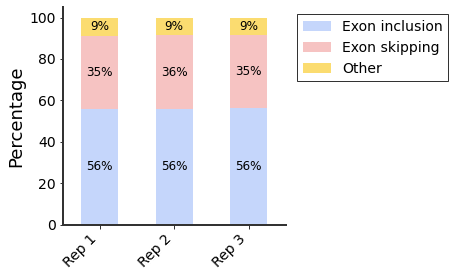

In [20]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#C5D6FB", '#F6C3C2', '#fbdc70', '#c1efb2', '#dcd7f1', 'yellow', 'black', 'purple',
                                             'pink', 'brown', 'orange', 'teal', 'coral', 'lightblue', 'lime', 'lavender', 'turquoise', 'darkgreen', 'tan', 'salmon', 'gold'])
fig, ax = plt.subplots(figsize=(6/1.5, 6/1.5))
totals = np.zeros(3)
# plots = []
# for idx, row in enumerate(summary_data):
#     plots.append(ax.bar(np.arange(len(row)), row, bottom=totals))
#     totals += row

summary_data[['Exon inclusion', 'Exon skipping', 'Other']].plot.bar(stacked=True, ax=ax)

prevs = np.zeros(3)
for idx, rep_row in enumerate(summary_data[['Exon inclusion', 'Exon skipping', 'Other']].values):
    for jdx, val in enumerate(rep_row):
        ax.text(idx, prevs[idx] + val / 2, f'{val:.0f}%', ha='center', va='center', fontsize=12, rotation=0)
        prevs[idx] += val

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Rep 1', 'Rep 2', 'Rep 3'], rotation=45, ha='right')
# ax.legend(reversed([plots[i][0] for i in range(7)]), reversed(['Exon inclusion', 'Exon skipping', 'Splicing in exon',
#           'Unidentified splicing products', 'Exon 1 unidentified', 'N in read', 'Intron 1 retention']), loc='upper left', bbox_to_anchor=(1.02, 1))
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
ax.set_ylabel('Percentage')



fig.savefig('./figs/figure_1c.svg', pad_inches=0.1,
            bbox_inches='tight')
fig.savefig('./figs/figure_1c.pdf', pad_inches=0.1,
            bbox_inches='tight')

# measured PSI vs hts PSI

In [25]:
exons = [
    'GCGGCACCTACTACAATGTCCCCCGCTGCATACACTCGGAGCCAATAGGGCGCCTATAGAGTGTAGTCCT',
    'TCGCACCGCAGGTTCGGTTTTTTGGTATAATACGCGGCACTCCAAAATTACTCTGGGGCACCCTCACCAG',
    'GCCCGAAAGCTCCCTACTGCAGTTTACGACCCTTAAGGCTTGGGTGCTCTTACGCGCTGATCGATATAAG',
    'CCCTACCCGCCCTCGTCCCCAGGACACCCTTTCCGCCGCAAGTTATCCGCCAAGTACACAACTTAATGGT',
    'GGTGTCCCCCACTATCGACCTCATCAGTAATCAATCCGAGCGACCGCCTCATCCCAAAGGCACACGTCCA'
]

In [26]:
def get_psi(exon, all_barcode_statistics):
    num = 0
    denom = 0

    for bs in all_barcode_statistics:
        top = bs.query(f'exon == "{exon}"')['num_exon_inclusion'].iloc[0]
        num += top
        denom += bs.query(f'exon == "{exon}"')['num_exon_skipping'].iloc[0] + top

    psi = num / denom
    return psi

In [27]:
x_scatter = [get_psi(exon, all_barcode_statistics) for exon in exons]

In [28]:
y_scatter = [0.08, 0.31, 0.82, 0.89, 0.98]

In [29]:
def rmse(a, b):
    out = 0
    for ai, bi in zip(a, b):
        out += (ai - bi) ** 2
    return np.sqrt(out)

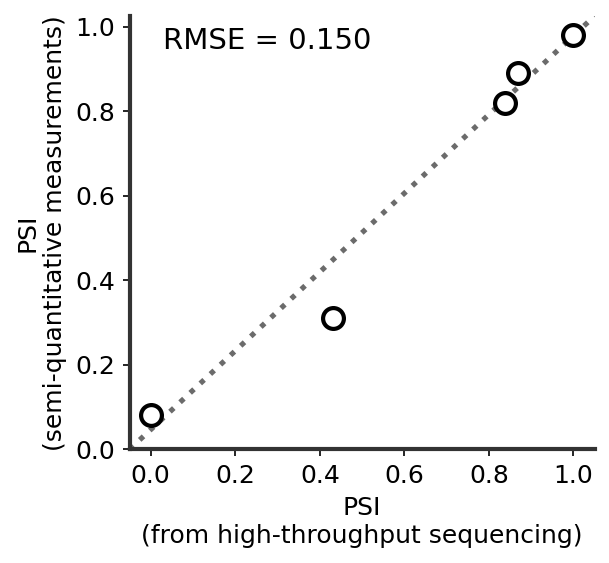

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

ax.scatter(x_scatter, y_scatter, s=100, linewidth=2, color='w', edgecolor='k', zorder=1)

ax.set_ylabel('PSI\n(semi-quantitative measurements)', fontsize=12)
ax.set_xlabel('PSI\n(from high-throughput sequencing)', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set(adjustable='box', aspect='equal')
ax.set_xticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 6))

ax.text(3e-2, 1., f'RMSE = {rmse(x_scatter, y_scatter):.3f}', ha='left', fontsize=14, va='top')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(xlim, ylim, color='#6b6b6b', zorder=0, linestyle=':', label='$x = y$')
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

fig.savefig('./figs/psi_measured_vs_high_throughput_sequencing.svg', pad_inches=0.1,
            bbox_inches='tight')


# Extended figure 1a

In [31]:
def to_target_data(df):
    return np.array(df.num_exon_inclusion /
                    (df.num_exon_inclusion + df.num_exon_skipping))

In [32]:
lib_nums = [11, 12, 13]
MIN_READS = 20

In [33]:
datasets = {}

In [34]:
for idx in [0, 1, 2]:
    dataset = all_barcode_statistics[idx]
    dataset[
    "others"] = dataset.num_unknown_splicing + dataset.num_intron_retention + dataset.num_bad_reads + dataset.num_bad_exon1
    dataset[
        "total"] = dataset.others + dataset.num_exon_skipping + dataset.num_exon_inclusion + dataset.num_splicing_in_exon
        
    dataset['psi'] = to_target_data(dataset)
    
    datasets[lib_nums[idx]] = dataset

In [35]:
merged_data = datasets[11].join(datasets[12], lsuffix='_11', how='inner').join(datasets[13], lsuffix='_12', rsuffix='_13', how='inner')

In [36]:
merged_data = merged_data.dropna()

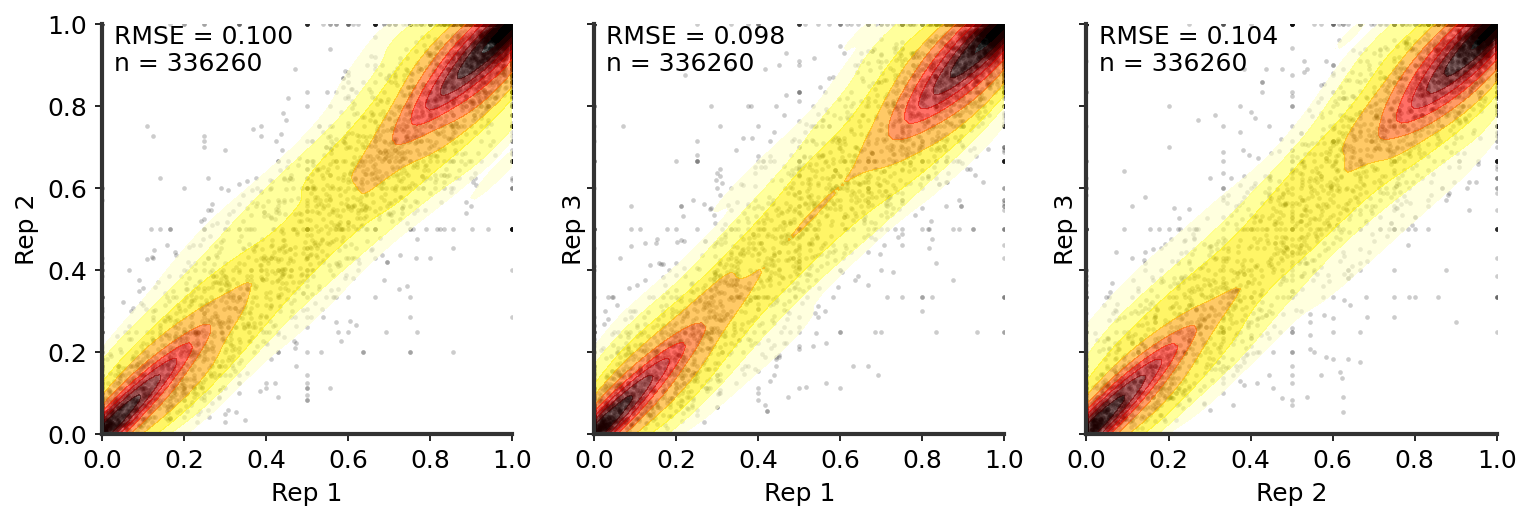

In [37]:
fig, axarr = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharex=True, sharey=True)

axarr = np.array([[axarr[0], np.nan], [axarr[1], axarr[2]]])

plot_data = [
    {'left': 12, 'right': 11, 'row':0, 'col':0},
    {'left': 13, 'right': 11, 'row':1, 'col':0},
    {'left': 13, 'right': 12, 'row':1, 'col':1}
]

rep_lookup = {11:1, 12:2, 13:3}

for plot_dict in plot_data:
    left_data = merged_data[f"psi_{plot_dict['left']}"].values
    right_data = merged_data[f"psi_{plot_dict['right']}"].values
    
    ax = axarr[plot_dict['row'], plot_dict['col']]
    
    x, y = figutils.subsample_points(left_data, right_data, max_points=10000)
    x, y = y, x
    xy = np.vstack([x,y])
    kde = gaussian_kde(xy)
    z = kde(xy)
    
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    cont = axarr[plot_dict['row'], plot_dict['col']].scatter(x, y, alpha=0.2, s=5,
                                                             cmap=plt.cm.hot_r, linewidth=0., c='k')
    
    grid_resolution = 100
    A, B = np.meshgrid(np.linspace(0, 1, grid_resolution), np.linspace(0, 1, grid_resolution))
    xygrid = np.vstack([A.flatten(), B.flatten()])
    zgrid = kde(xygrid)
    
    ax.contourf(A, B,
                np.log(zgrid).reshape(*A.shape), 10000, origin='lower',
                cmap=plt.cm.hot_r, alpha=0.6, levels=np.linspace(-2, 3, 10))
    
    rmse = np.sqrt(((left_data - right_data) ** 2).mean())
    ax.set_xlabel(f"Rep {rep_lookup[plot_dict['right']]}", fontsize=12)
    ax.set_ylabel(f"Rep {rep_lookup[plot_dict['left']]}", fontsize=12)
    ax.text(3e-2, 1., f'RMSE = {rmse:.3f}\nn = {left_data.shape[0]}', ha='left', fontsize=12, va='top')
    ax.set(adjustable='box', aspect='equal')
    

for axrow in axarr:
    for ax in axrow:
        if not isinstance(ax, float):
            ax.tick_params(axis='x', labelsize=12)
            ax.tick_params(axis='y', labelsize=12)

fig.savefig('./figs/extended_figure_1a.svg', pad_inches=0.1,
            bbox_inches='tight')
fig.savefig('./figs/extended_figure_1a.pdf', pad_inches=0.1,
            bbox_inches='tight')

# Lorenz plot

In [48]:
X = pd.read_csv(BS06911A_coupling_csv_path)

In [51]:
df = X[['barcode', 'num_reads']]
df.columns = ['barcode', 'cnt']

In [54]:
df_filtered = df[df["cnt"] > 1]
t = np.cumsum(list(reversed(sorted(list(df_filtered["cnt"])))))
t = t/t[-1]

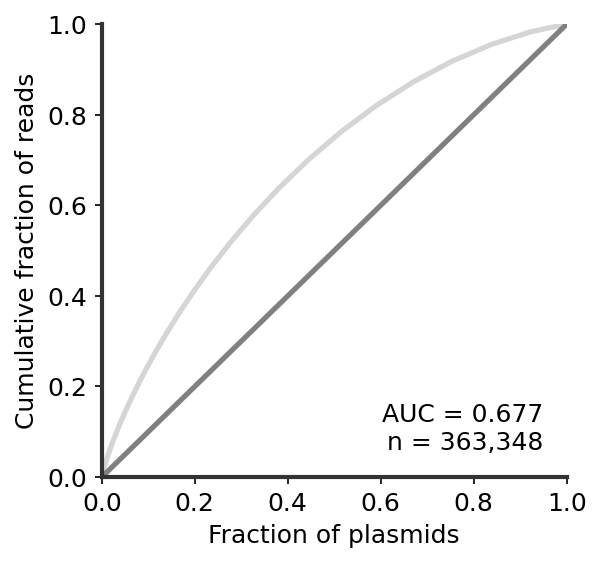

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True, dpi=150)

ax.plot([i/len(t) for i in range(len(t))], t, color='#d5d5d5') 
# ax.set_xticks(np.arange(0,len(t),100000))
ax.set_xlabel("Fraction of plasmids", fontsize=12)
ax.set_ylabel("Cumulative fraction of reads", fontsize=12)
ax.text(0.95, 0.05,f'AUC = 0.677\nn = 363,348', ha='right', va='bottom',
        transform=ax.transAxes, fontsize=12)
ax.plot([0, 1],color='gray')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.margins(y=0, x=0)

fig.savefig('./figs/lorenz.svg', pad_inches=0.1,
    bbox_inches='tight')
fig.savefig('./figs/lorenz.pdf', pad_inches=0.1,
    bbox_inches='tight')

plt.show()